In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.optimize import fsolve, minimize
from scipy.integrate import quad
from numpy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape
from collections import deque

In [2]:
# Import functions from other notebooks using %run
%run estimation.ipynb
%run MDP_core_allocation.ipynb

In [3]:
def simulate_until_n_departures(jobs, jobs_in_system_ids, current_time, n_departures, amdahl_pars, model_pars, pi_optimal, M):
    """
    Simulate queue until exactly n_departures occur, continuing from existing jobs in system
    
    Parameters:
    - jobs: list of ALL Job objects (already created with arrival/service times, categories)
    - jobs_in_system_ids: list of job IDs currently in system (from previous window)
    - current_time: current simulation time
    - n_departures: number of departures to wait for in this window
    - amdahl_pars: [p1, p2] for simulation (TRUE parameters)
    - model_pars: [lam, mu, cores, alpha]
    - pi_optimal: optimal policy matrix
    - M: max queue size for policy lookup
    
    Returns: events, n_jobs_after_events, core_alloc_after_events, jobs_in_system_ids, current_time
    """
    lam, mu, total_cores, alpha = model_pars
    p1, p2 = amdahl_pars
    
    events = []
    n_jobs_in_system_just_after_events = []
    core_allocation_just_after_events = []
    
    job_ids_in_system = jobs_in_system_ids.copy()
    departure_count = 0
    
    # Find next job to arrive
    next_arrival_id = None
    for jid in range(len(jobs)):
        if jobs[jid].arrival_time >= current_time and jid not in job_ids_in_system:
            next_arrival_id = jid
            break
    
    # Count jobs by category
    n_jobs_in_system = np.array([
        sum([1 for jid in job_ids_in_system if jobs[jid].category == 1]),
        sum([1 for jid in job_ids_in_system if jobs[jid].category == 2])
    ])
    
    while departure_count < n_departures:
        # Time until next arrival
        if next_arrival_id is not None and next_arrival_id < len(jobs):
            time_until_next_arrival = jobs[next_arrival_id].arrival_time - current_time
        else:
            time_until_next_arrival = math.inf
        
        # Time until next departure
        if len(job_ids_in_system) == 0:
            time_until_next_departure = math.inf
        else:
            # Core allocation from optimal policy
            n1, n2 = min(n_jobs_in_system[0], M), min(n_jobs_in_system[1], M)
            fraction_to_type1 = pi_optimal[n1, n2]
            current_core_allocation = np.array([fraction_to_type1 * total_cores, (1 - fraction_to_type1) * total_cores])
            
            # Cores per job and speed-up
            cores_per_job = np.array([
                current_core_allocation[0]/n_jobs_in_system[0] if n_jobs_in_system[0] > 0 else 0,
                current_core_allocation[1]/n_jobs_in_system[1] if n_jobs_in_system[1] > 0 else 0
            ])
            speed_up_values = np.array([speed_up(p1, cores_per_job[0]), speed_up(p2, cores_per_job[1])])
            
            # Time until departure
            expected_times = np.array([
                jobs[jid].residual_service_time / speed_up_values[int(jobs[jid].category) - 1]
                for jid in job_ids_in_system
            ])
            time_until_next_departure = np.min(expected_times)
        
        # Break if no more events possible
        if time_until_next_arrival == math.inf and time_until_next_departure == math.inf:
            break
        
        # Determine next event
        if time_until_next_arrival < time_until_next_departure:
            time_step = time_until_next_arrival
            event_type = 'arrival'
            event_job_id = next_arrival_id
        else:
            time_step = time_until_next_departure
            event_type = 'departure'
            event_job_id = job_ids_in_system[np.argmin(expected_times)]
        
        # Update residual service times
        if len(job_ids_in_system) > 0:
            for jid in job_ids_in_system:
                spd = speed_up_values[int(jobs[jid].category) - 1]
                jobs[jid].residual_service_time -= spd * time_step
                jobs[jid].history.append([spd, time_step])
        
        current_time += time_step
        
        # Process event
        if event_type == 'arrival':
            events.append([current_time, 'arrival', event_job_id])
            job_ids_in_system.append(event_job_id)
            n_jobs_in_system[int(jobs[event_job_id].category) - 1] += 1
            
            # Find next arrival
            next_arrival_id = None
            for jid in range(event_job_id + 1, len(jobs)):
                if jobs[jid].arrival_time >= current_time and jid not in job_ids_in_system:
                    next_arrival_id = jid
                    break
        else:
            events.append([current_time, 'departure', event_job_id])
            job_ids_in_system.remove(event_job_id)
            n_jobs_in_system[int(jobs[event_job_id].category) - 1] -= 1
            jobs[event_job_id].departure_time = current_time
            departure_count += 1
        
        # Record state
        n_jobs_in_system_just_after_events.append(n_jobs_in_system.copy())
        n1, n2 = min(n_jobs_in_system[0], M), min(n_jobs_in_system[1], M)
        fraction = pi_optimal[n1, n2]
        core_allocation_just_after_events.append(np.array([fraction * total_cores, (1-fraction) * total_cores]))
    
    return events, n_jobs_in_system_just_after_events, core_allocation_just_after_events, job_ids_in_system, current_time


In [4]:
def iterative_algorithm(true_pars, initial_estimates, N, total_iterations):
    """
    Algorithm 1: Growing window sizes with per-window estimation
    
    Key differences from Algorithm 2:
    - Window k has N_k = N * sqrt(k) departures (growing)
    - Estimation uses ONLY data from current window (not cumulative)
    """
    # Extract true parameters
    lam, mu, cores, p1_true, p2_true, alpha, M = true_pars
    model_pars = [lam, mu, cores, alpha]
    amdahl_pars_true = [p1_true, p2_true]
    
    # Initialize estimates
    p1_est, p2_est = initial_estimates
    estimates_history = [initial_estimates]
    policies_history = []
    
    # Preprocessing: Generate enough jobs upfront (generous buffer)
    # Use exponent for actual window size calculation
    exponent = 0.75
    # Calculate buffer using exponent = 1 (linear growth) so it works for any exponent <= 1
    total_departures_estimate = sum([int(N * k) for k in range(1, total_iterations + 1)])
    # Generate more jobs than departures to ensure we have arrivals available
    total_jobs = int(total_departures_estimate * 2)  # 2x buffer
    
    arrival_times = generate_arrival_times(lam, total_jobs)
    service_times = generate_service_times(mu, total_jobs)
    job_categories = generate_job_categories(alpha, total_jobs)
    
    jobs = [Job() for i in range(total_jobs)]
    for i in range(total_jobs):
        jobs[i].identity = i
        jobs[i].arrival_time = arrival_times[i]
        jobs[i].service_time = service_times[i]
        jobs[i].residual_service_time = service_times[i]
        jobs[i].category = int(job_categories[i])
    
    # Simulation state
    jobs_in_system_ids = []
    current_time = 0.0
    
    print("="*70)
    print("ALGORITHM 1: GROWING WINDOWS + PER-WINDOW ESTIMATION")
    print("="*70)
    print(f"True parameters: p1 = {p1_true:.4f}, p2 = {p2_true:.4f}")
    print(f"Initial estimates: p1 = {p1_est:.4f}, p2 = {p2_est:.4f}")
    print(f"Strategy: N_k = N * sqrt(k), estimate using ONLY window k data")
    print(f"Base window size N = {N}, Total iterations = {total_iterations}")
    print("="*70)
    
    for iteration in range(1, total_iterations + 1):
        # Calculate window size for this iteration
        n_departures = int(N * np.power(iteration, exponent))
        
        print(f"\n--- Iteration {iteration}/{total_iterations} ---")
        print(f"Current estimates: p1 = {p1_est:.4f}, p2 = {p2_est:.4f}")
        print(f"Window size: {n_departures} departures (N * sqrt({iteration}) = {N} * {np.sqrt(iteration):.2f})")
        print(f"Jobs in system at start: {len(jobs_in_system_ids)}")
        
        # Step 1: Compute optimal policy
        est_pars = [lam, mu, cores, p1_est, p2_est, alpha, M]
        print("Computing optimal policy...")
        pi_optimal, V_optimal, Q_optimal = bellman_optimal_policy(est_pars)
        policies_history.append(pi_optimal)
        
        # Step 2: Simulate until n_departures occur
        print(f"Simulating until {n_departures} departures...")
        events, n_jobs, core_alloc, jobs_in_system_ids, current_time = simulate_until_n_departures(
            jobs, jobs_in_system_ids, current_time, n_departures,
            amdahl_pars_true, model_pars, pi_optimal, M
        )
        
        print(f"Simulated {len(events)} events, time = {current_time:.2f}")
        print(f"Jobs remaining in system: {len(jobs_in_system_ids)}")
        
        # Check if simulation generated any events
        if len(events) == 0:
            print("WARNING: No events generated! Keeping previous estimates.")
            estimates_history.append((p1_est, p2_est))
            continue
        
        # Step 3: Estimate using ONLY current window data
        print(f"Estimating from {len(events)} events in THIS window only...")
        estd_result = estimation(
            model_pars, jobs, jobs_in_system_ids,
            events, n_jobs, core_alloc
        )
        
        # DIAGNOSTIC OUTPUT
        print(f"Optimization success: {estd_result.success}")
        print(f"Optimization message: {estd_result.message}")
        print(f"Function value: {estd_result.fun:.2f}")
        print(f"Number of iterations: {estd_result.nit}")
        
        p1_est, p2_est = estd_result.x
        p1_est = np.clip(p1_est, 0.001, 0.999)
        p2_est = np.clip(p2_est, 0.001, 0.999)
        estimates_history.append((p1_est, p2_est))
        
        error_p1 = abs(p1_est - p1_true)
        error_p2 = abs(p2_est - p2_true)
        print(f"Updated estimates: p1 = {p1_est:.4f}, p2 = {p2_est:.4f}")
        print(f"Errors: Δp1 = {error_p1:.4f}, Δp2 = {error_p2:.4f}")
    
    print("\n" + "="*70)
    print("ALGORITHM COMPLETED")
    print("="*70)
    
    return estimates_history, policies_history


In [5]:
# True system parameters
lam = 2 # Arrival rate
mu = 1.5 # Mean service time
cores = 10 # Total number of cores
p1_true = 0.4 # Bad jobs - lower parallelizability
p2_true = 0.85 # Good jobs - higher parallelizability
alpha = 0.7 # Fraction of type 1 jobs
M = 10 # Maximum queue size for MDP

true_pars = [lam, mu, cores, p1_true, p2_true, alpha, M]

# Algorithm parameters
initial_estimates = [0.5, 0.5] # Start with neutral beliefs
N = 50 # Base window size
total_iterations = 100 # Number of estimation-optimization iterations

# Run the iterative algorithm
estimates_history, policies_history = iterative_algorithm(
    true_pars, 
    initial_estimates, 
    N, 
    total_iterations
)

ALGORITHM 1: GROWING WINDOWS + PER-WINDOW ESTIMATION
True parameters: p1 = 0.4000, p2 = 0.8500
Initial estimates: p1 = 0.5000, p2 = 0.5000
Strategy: N_k = N * sqrt(k), estimate using ONLY window k data
Base window size N = 50, Total iterations = 100

--- Iteration 1/100 ---
Current estimates: p1 = 0.5000, p2 = 0.5000
Window size: 50 departures (N * sqrt(1) = 50 * 1.00)
Jobs in system at start: 0
Computing optimal policy...
Simulating until 50 departures...
Simulated 100 events, time = 28.07
Jobs remaining in system: 0
Estimating from 100 events in THIS window only...
Optimization success: True
Optimization message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Function value: 1.66
Number of iterations: 8
Updated estimates: p1 = 0.2120, p2 = 0.7962
Errors: Δp1 = 0.1880, Δp2 = 0.0538

--- Iteration 2/100 ---
Current estimates: p1 = 0.2120, p2 = 0.7962
Window size: 84 departures (N * sqrt(2) = 50 * 1.41)
Jobs in system at start: 0
Computing optimal policy...
Simulating until 84 departu

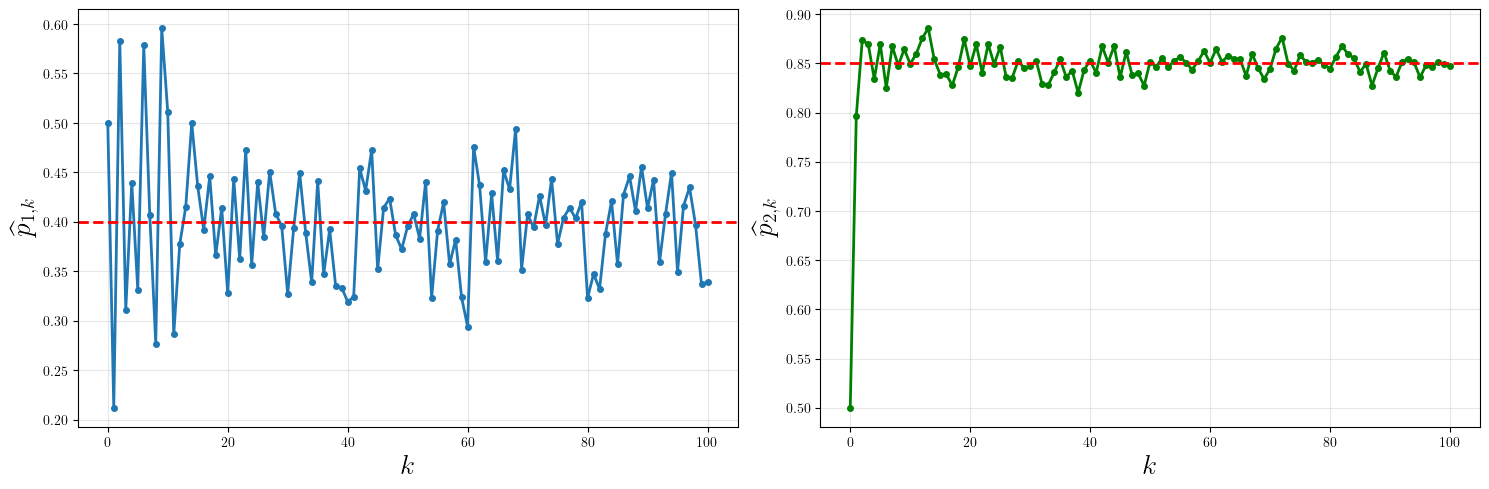


FINAL RESULTS
True parameters:     p1 = 0.4000, p2 = 0.8500
Initial estimates:   p1 = 0.5000, p2 = 0.5000
Final estimates:     p1 = 0.3391, p2 = 0.8476
Final errors:        Δp1 = 0.0609, Δp2 = 0.0024


In [6]:
# Visualize convergence of estimates
p1_estimates = [est[0] for est in estimates_history]
p2_estimates = [est[1] for est in estimates_history]

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot p_1 estimates
ax1.plot(range(len(p1_estimates)), p1_estimates, 'o-', linewidth=2, markersize=4)
ax1.axhline(y=p1_true, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel(r'$k$', fontsize=20)
ax1.set_ylabel(r'$\widehat{p}_{1,k}$', fontsize=20)
ax1.grid(True, alpha=0.3)

# Plot p_2 estimates
ax2.plot(range(len(p2_estimates)), p2_estimates, 'o-', linewidth=2, markersize=4, color='green')
ax2.axhline(y=p2_true, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel(r'$k$', fontsize=20)
ax2.set_ylabel(r'$\widehat{p}_{2,k}$', fontsize=20)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_plot_algo1.png', dpi=300)
plt.show()

# Print final results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"True parameters:     p1 = {p1_true:.4f}, p2 = {p2_true:.4f}")
print(f"Initial estimates:   p1 = {initial_estimates[0]:.4f}, p2 = {initial_estimates[1]:.4f}")
print(f"Final estimates:     p1 = {p1_estimates[-1]:.4f}, p2 = {p2_estimates[-1]:.4f}")
print(f"Final errors:        Δp1 = {abs(p1_estimates[-1] - p1_true):.4f}, Δp2 = {abs(p2_estimates[-1] - p2_true):.4f}")
print("="*60)


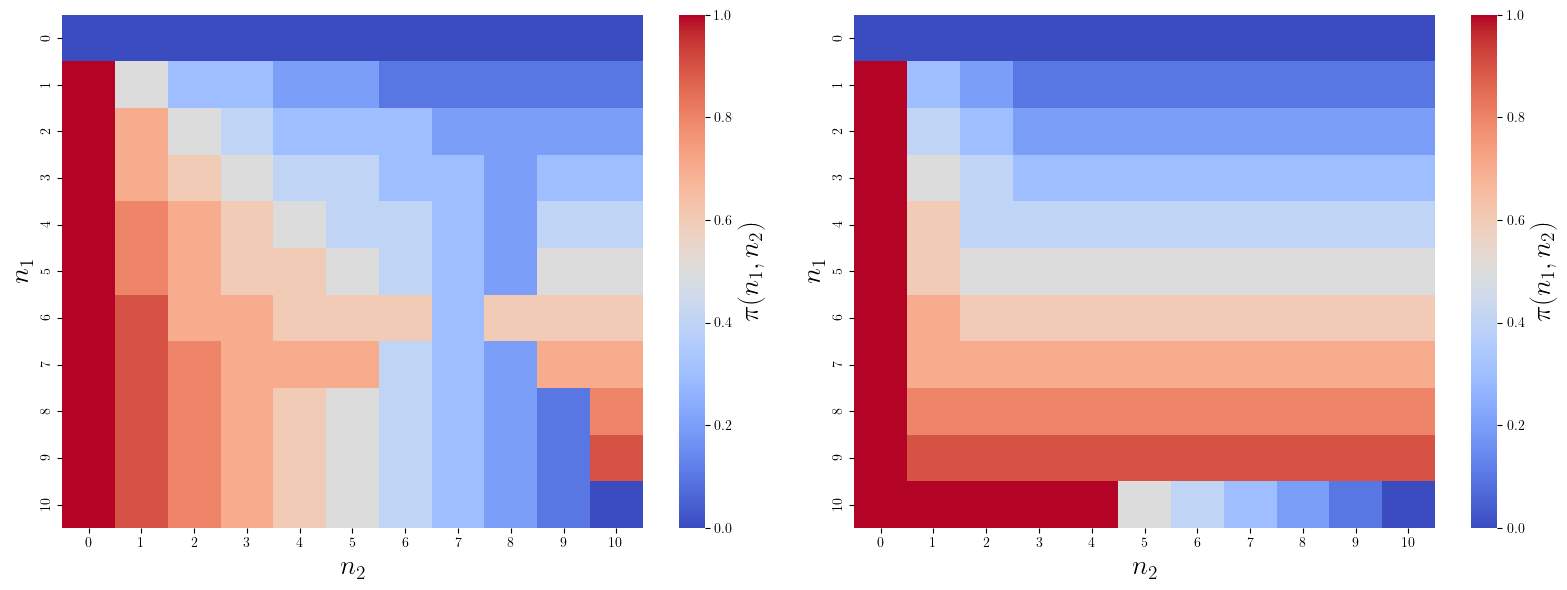

\nPolicy Interpretation:
- Red = more cores to Type 1 jobs (lower parallelizability)
- Blue = more cores to Type 2 jobs (higher parallelizability)


In [7]:
# Optional: Visualize policy evolution
if len(policies_history) >= 2:
    # Enable LaTeX rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # First policy
    heatmap1 = sns.heatmap(policies_history[0], ax=axes[0], cmap="coolwarm", 
                           annot=False, cbar=True, vmin=0, vmax=1)
    heatmap1.collections[0].colorbar.set_label(r'$\pi\big(n_1, n_2\big)$', fontsize=20)
    axes[0].set_xlabel(r'$n_2$', fontsize=20)
    axes[0].set_ylabel(r'$n_1$', fontsize=20)
    
    # Last policy
    heatmap2 = sns.heatmap(policies_history[-1], ax=axes[1], cmap="coolwarm", 
                           annot=False, cbar=True, vmin=0, vmax=1)
    heatmap2.collections[0].colorbar.set_label(r'$\pi\big(n_1, n_2\big)$', fontsize=20)
    axes[1].set_xlabel(r'$n_2$', fontsize=20)
    axes[1].set_ylabel(r'$n_1$', fontsize=20)
    
    plt.tight_layout()
    plt.savefig('policy_evolution_algo1.png', dpi=300)
    plt.show()
    
    print("\\nPolicy Interpretation:")
    print("- Red = more cores to Type 1 jobs (lower parallelizability)")
    print("- Blue = more cores to Type 2 jobs (higher parallelizability)")


In [ ]:
# Speed-up sensitivity to core allocation changes - why lower p values are harder to estimate

def speed_up(p, n_cores):
    return 1/(1 - p*(1 - 1/max(1, n_cores)))

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Speed-up sensitivity to core allocation changes
cores_range = np.arange(1, 21)
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]

for p in p_values:
    speed_ups = [speed_up(p, c) for c in cores_range]
    ax.plot(cores_range, speed_ups, 'o-', label=f'p = {p}', linewidth=2, markersize=4)

ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$s(z;p)$', fontsize=20)
# ax.set_title('Speed-up vs Number of Cores for Different p Values', fontsize=14)
ax.legend(fontsize=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('speed_up_sensitivity_algo1.png', dpi=300)
plt.show()

print("\n" + "="*60)
print("WHY LOWER p VALUES ARE HARDER TO ESTIMATE")
print("="*60)
print("• Lower p values (red/orange curves) show modest speed-up improvements")
print("• Higher p values (green curve) show dramatic speed-up gains")
print("• This makes it harder to distinguish different p₁ values from observed speed-ups")
print("• Type 2 jobs (p₂ = 0.9) respond dramatically to core allocation changes")
print("• Type 1 jobs (p₁ = 0.4) show modest improvements, making estimation harder")
print("="*60)
